In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from tqdm.notebook import tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1.  Cинтетический Causal Impact без эффекта

In [11]:
# Генерируем синтетические данные с помощью ARMA процесса, где y напрямую зависит от x0
# Также добавим тренд

np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)

seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 30)*3

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0 # x0 - ковариата с трендом
x1 = 55 + arma_process.generate_sample(nsample=1196) # x1 ковариата (не будет скоррелированна)
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y + seasonal_component_monthly # целевая метрика с терндом скоррелированная с ковариатой x0

data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]] # период до treatment
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]] # период после treatment
ts_data.head(10)

,y,x0,x1
2019-01-01,189.447228,100.496714,54.980362
2019-01-02,189.542743,99.766573,55.556418
2019-01-03,192.498641,100.703571,55.112631
2019-01-04,193.004742,101.396530,56.341614
2019-01-05,190.418708,99.505771,54.856902
2019-01-06,191.445845,99.888956,54.599214
2019-01-07,196.233991,101.630686,55.202455
2019-01-08,194.044302,100.475579,55.502807
2019-01-09,191.364107,99.474708,54.948299
2019-01-10,194.457539,100.691933,55.050932


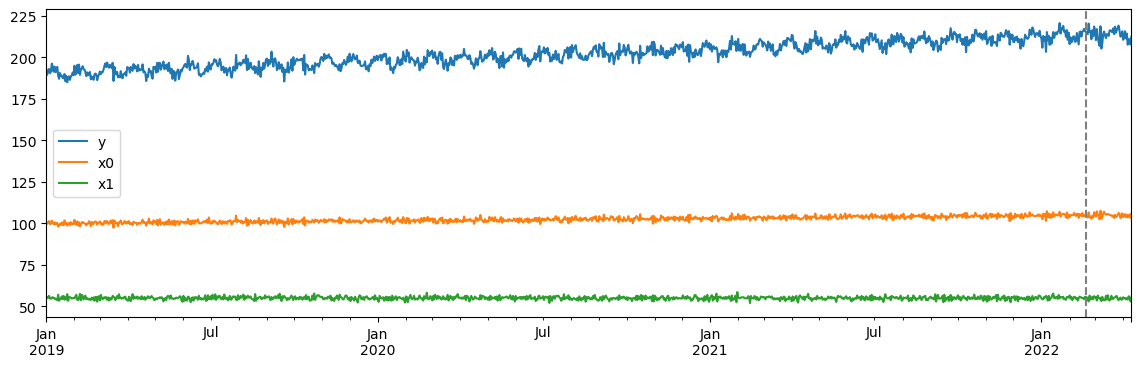

In [12]:
# отрисуем наши переменные
plt.figure(figsize = (14, 4))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
ts_data.x1.plot(label = 'x1')
plt.legend()
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--') # момент гипотетического treatment

In [13]:
# проверим корреляцию рядов
ts_data.corr().style.background_gradient(cmap='coolwarm', axis=None)

,y,x0,x1
y,1.000000,0.902258,-0.021351
x0,0.902258,1.000000,-0.012216
x1,-0.021351,-0.012216,1.000000


<Axes: xlabel='x0', ylabel='y'>

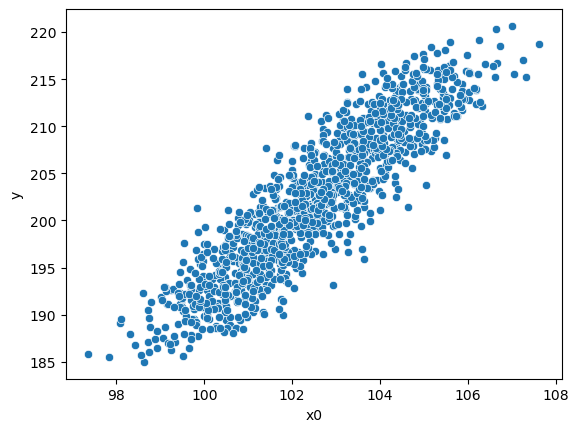

In [6]:
# посмотрим зависимость на графике y и x0
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

<Axes: xlabel='x1', ylabel='y'>

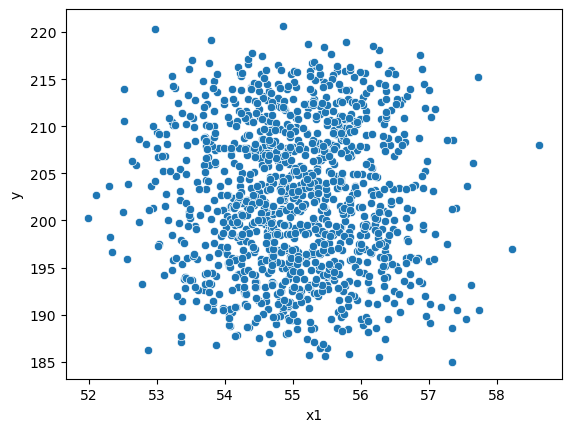

In [7]:
# посмотрим зависимость на графике y и x1
sns.scatterplot(x= ts_data.x1, y = ts_data.y)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90813D-01    |proj g|=  8.06086D-01

At iterate    5    f= -2.43488D-01    |proj g|=  3.45452D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17      1     0     0   5.893D-05  -2.450D-01
  F = -0.24499522135180390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/shikhtorinoleg/micromamba/envs/rhda/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


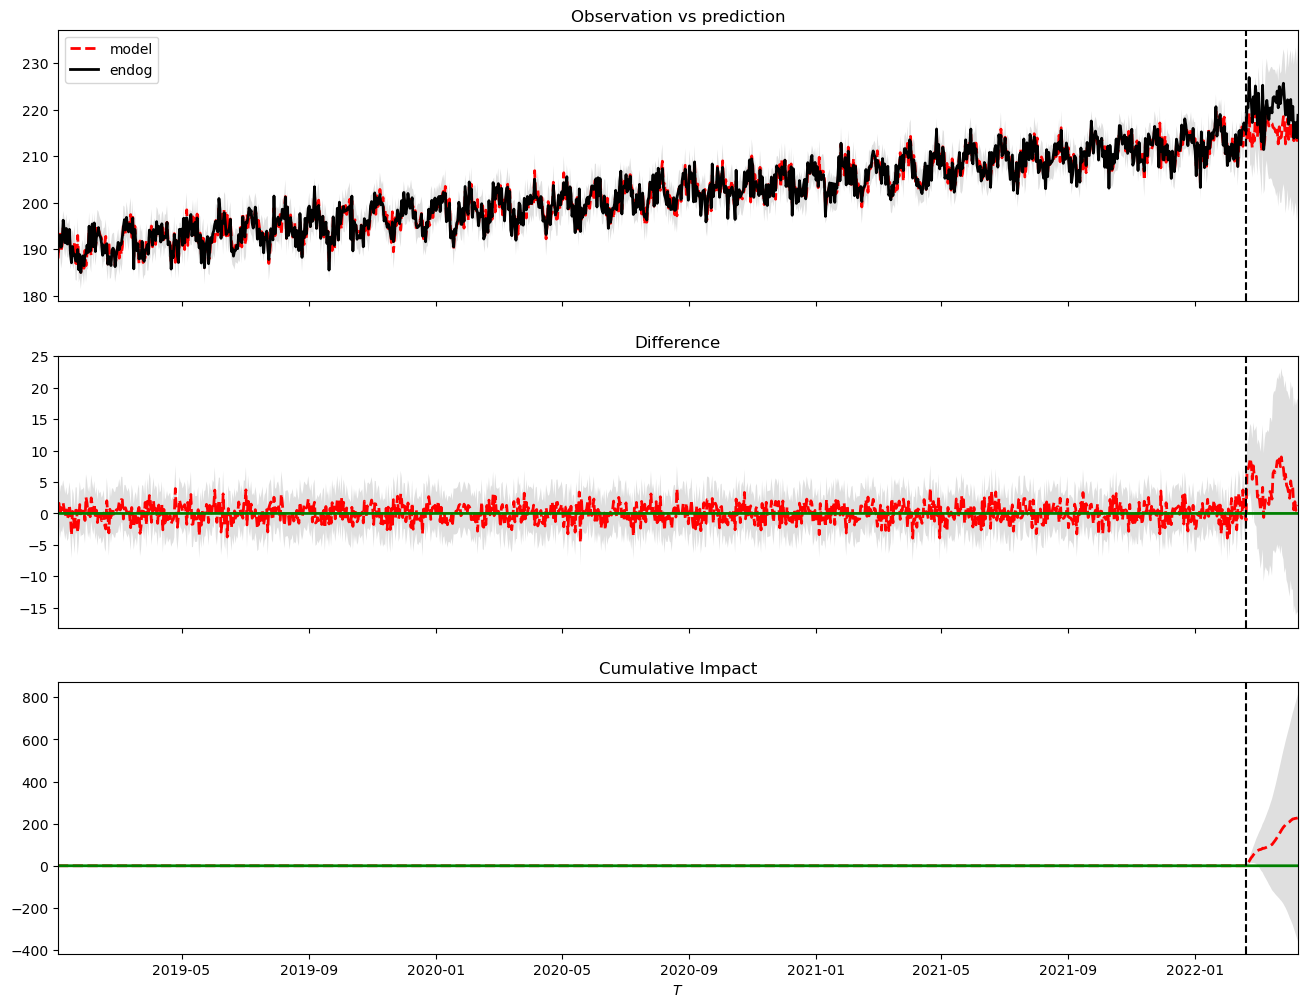

                              Average      Cumulative
Actual                            220           11010
Predicted                         215           10783
95% CI                     [203, 227]  [10196, 11370]
                                                     
Absolute Effect                     4             227
95% CI                       [16, -7]     [814, -359]
                                                     
Relative Effect                  2.1%            2.1%
95% CI                  [7.6%, -3.3%]   [7.6%, -3.3%]
                                                     
P-value                          0.0%                
Prob. of Causal Effect         100.0%                
None


In [20]:
# проведем causal impact анализ на данных без эффекта. выведем plot и summary
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01, model_args={"nseasons":30})
ci.run()
ci.plot(figsize = (16, 12))
print(ci.summary())

Мы не заложили эффект, что показывает и Causal Impact что изменение -0.09% с 99% доверительным интервалом [-0.45%, 0.26%] и с p-value = 0.26. При порверке гипотезы в Causal Impact, мы проверяем альтернативную гипотезу о том что есть разница против нулевой гипотезы что разницы между метрикой до изменении и после нет. В данном случае p-value = 0.26, мы не можем отвергнуть H0

## 2. Синтетический Causal impact с эффектом
### Давайте попробуем симулировать эффект, добавим +3% с определённого момента

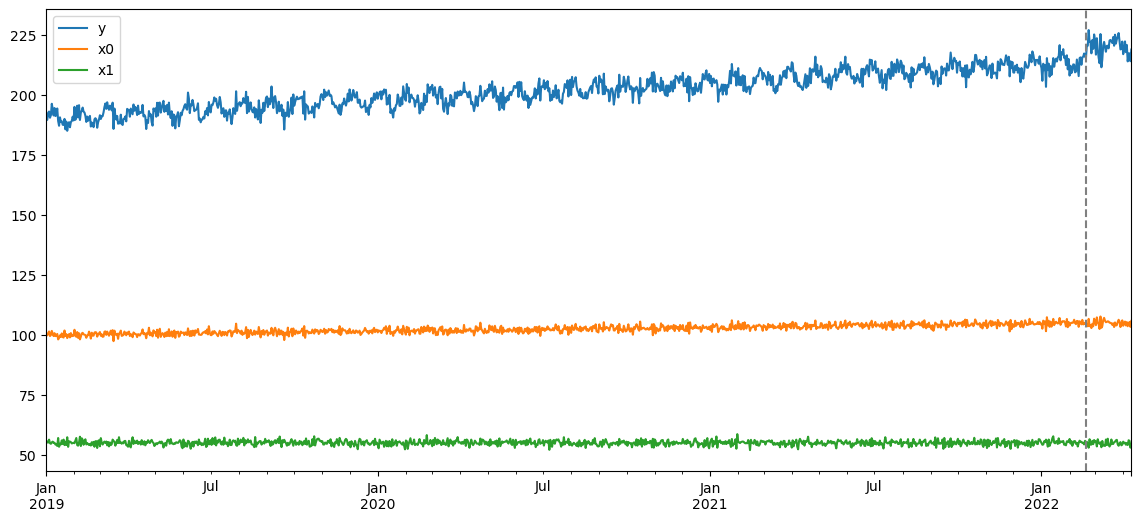

In [16]:
# Генерируем синтетические данные с помощью ARMA процесса, где y напрямую зависит от x0
# Также добавим тренд и сезонность

np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)


seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 30)*3

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0 # x0 - ковариата с трендом
x1 = 55 + arma_process.generate_sample(nsample=1196) # x1 ковариата (не будет скоррелированна)
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y + seasonal_component_monthly # целевая метрика с терндом скоррелированная с ковариатой x0

data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]] # период до treatment
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]] # период после treatment

ts_data.loc[ts_post_period[0]:ts_post_period[-1], 'y'] *= 1.03
#ts_data.head(10)

plt.figure(figsize = (14, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
ts_data.x1.plot(label = 'x1')
plt.legend()
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--')

In [17]:
ts_data

,y,x0,x1
2019-01-01,189.447228,100.496714,54.980362
2019-01-02,189.542743,99.766573,55.556418
2019-01-03,192.498641,100.703571,55.112631
2019-01-04,193.004742,101.396530,56.341614
2019-01-05,190.418708,99.505771,54.856902
...,...,...,...
2022-04-06,213.894857,103.580886,54.091009
2022-04-07,217.221304,104.661552,56.071997
2022-04-08,217.218053,105.371585,55.820850
2022-04-09,213.969635,103.321820,52.989642


In [18]:
# посчитаем корреляцию 
ts_data.loc[:ts_pre_period[-1]].corr().style.background_gradient(cmap='coolwarm', axis=None)

,y,x0,x1
y,1.000000,0.899245,-0.011420
x0,0.899245,1.000000,0.000111
x1,-0.011420,0.000111,1.000000


<Axes: xlabel='x0', ylabel='y'>

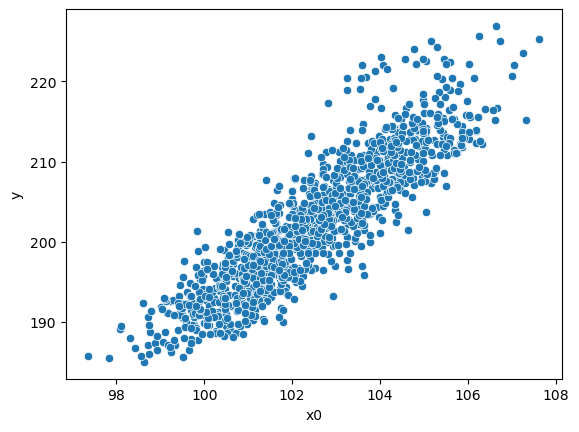

In [19]:
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90813D-01    |proj g|=  8.06086D-01

At iterate    5    f= -2.43488D-01    |proj g|=  3.45452D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17      1     0     0   5.893D-05  -2.450D-01
  F = -0.24499522135180390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/shikhtorinoleg/micromamba/envs/rhda/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


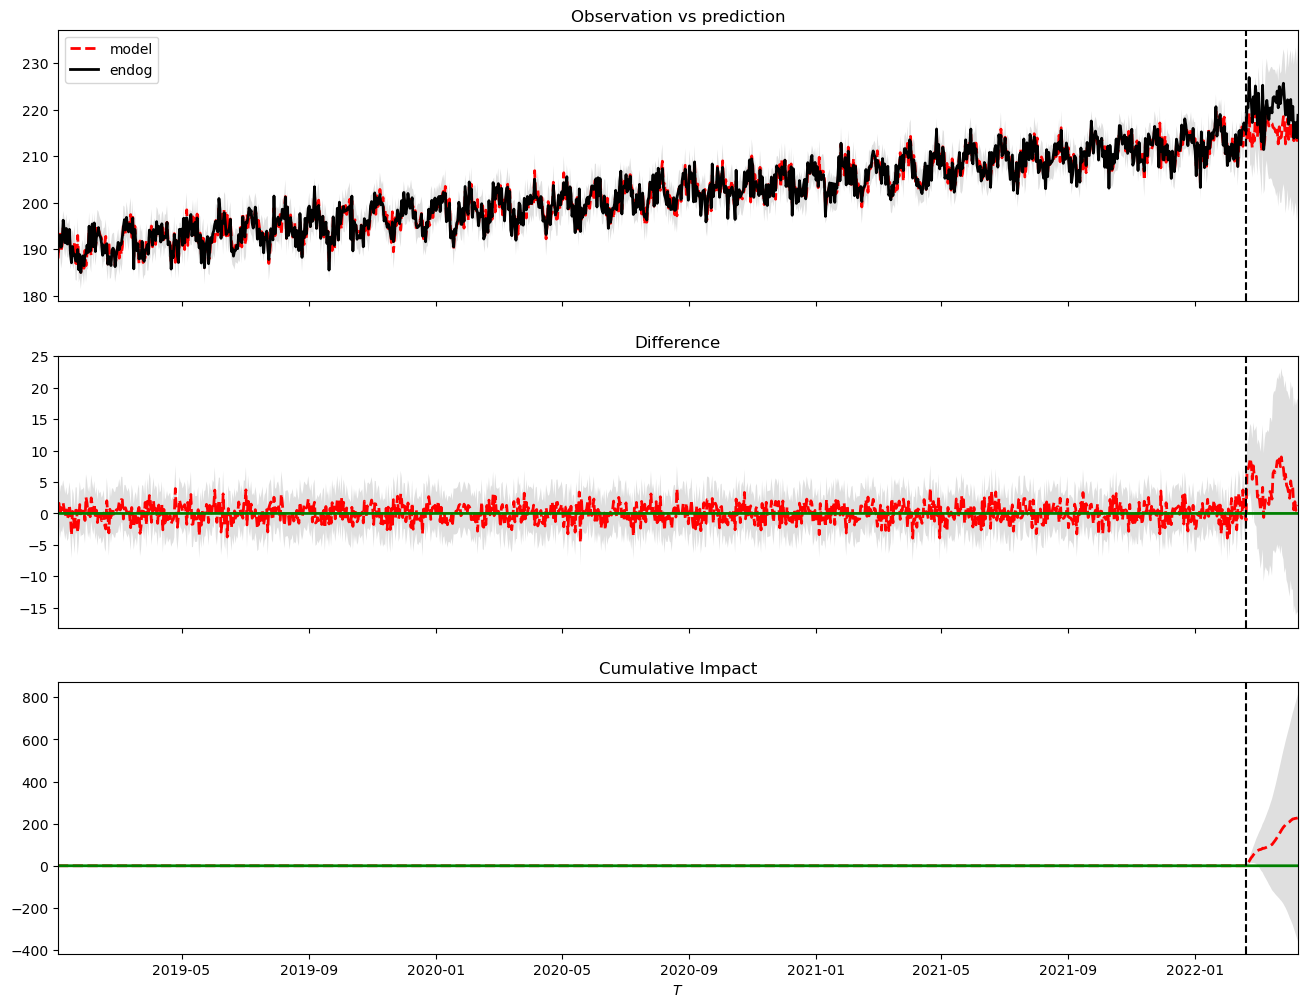

                              Average      Cumulative
Actual                            220           11010
Predicted                         215           10783
95% CI                     [203, 227]  [10196, 11370]
                                                     
Absolute Effect                     4             227
95% CI                       [16, -7]     [814, -359]
                                                     
Relative Effect                  2.1%            2.1%
95% CI                  [7.6%, -3.3%]   [7.6%, -3.3%]
                                                     
P-value                          0.0%                
Prob. of Causal Effect         100.0%                
None


In [21]:
# проведем causal impact анализ на данных с 3% эффектом. выведем plot и summary
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01, model_args={"nseasons":30})
ci.run()
ci.plot(figsize = (16, 12))
print(ci.summary())

Видим что CI нашел  заложенный нами эффект в 3%

## 3. Обращение к summary модели
Бывает полезно обратиться к модели. Давайте рассмотрим несколько методов обращения к объектам

In [29]:
# можно обратится к summary s виде таблицы
ci.summary()  #.loc['rel_effect', 'average']
# ci.summary(output="report")

                              Average      Cumulative
Actual                            220           11010
Predicted                         215           10783
95% CI                     [203, 227]  [10196, 11370]
                                                     
Absolute Effect                     4             227
95% CI                       [16, -7]     [814, -359]
                                                     
Relative Effect                  2.1%            2.1%
95% CI                  [7.6%, -3.3%]   [7.6%, -3.3%]
                                                     
P-value                          0.0%                
Prob. of Causal Effect         100.0%                


In [56]:
# С помощью этого метода можно вызвать общую информацию по регрессионной модели, включая коэффициенты параметров моделей, их стат. значимость, критерий Акаике, Льюнга-Бокса и т.д.
# sigma2.irregular - шум
# sigma2.level - тренд
# sigma2.freq_seasonal_* - сезонный компонент зажанной периодичности *
# beta.x - коэффициент при регрессорах
# ci.trained_model.summary()
ci.results.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                 1146
Model:                    local level   Log Likelihood                 280.765
Date:                Wed, 13 Mar 2024   AIC                           -553.529
Time:                        20:44:27   BIC                           -533.356
Sample:                             0   HQIC                          -545.913
                               - 1146                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0125      0.001     10.665      0.000       0.010       0.015
sigma2.level         0.0152      0.002      9.543      0.000       0.012       0.018
beta.x1              0.4536      0.007     60.756      0.000       0.439       0.468
beta.x2             -0.0047      0.004     -1.106      0.269      -0.013       0.004
===================================================================================
Ljung-Box (L1) (Q):                   3.99   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.05   Prob(JB):                         0.40
Heteroskedasticity (H):               1.15   Skew:                            -0.08
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Так же отдельно от общей информации по регрессионной модели, можно отдельно вывести значения Z - статистики (так же можно и T - статистики) по параметрам модели, а так же их p-value значения для проверки на стат. значимость. И доверительные интервалы как нижние, так и верхние

In [59]:
# можно обращаться к z-статистикам проверки значимости коэффициентов в модели
# ci.trained_model.zvalues
ci.results.results.zvalues

array([10.66485078,  9.54306394, 60.75631092, -1.1057797 ])

In [62]:
# проверка коэффициентов модели на стат значимость
# ci.trained_model.pvalues > 0.01
ci.results.results.pvalues > 0.01

array([False, False, False,  True])

In [74]:
# доверительные интервалы для коэффициентов модели
# ci.trained_model.conf_int()
ci.results.results.conf_int()

array([[ 0.01020409,  0.01479912],
       [ 0.01208345,  0.01832974],
       [ 0.4389736 ,  0.46823979],
       [-0.01313863,  0.00366072]])

In [33]:
# Этим методом можно посмотреть на предсказанные значения по каждому дню, их доверительные интервалы, разницу между факт.
# и предсказанными значениями, и т.д.
ci.inferences

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
2019-01-01,189.447228,189.447228,198.070592,-19038.087378,19434.228562,198.070592,-19038.087378,19434.228562,-8.623365,19227.534606,-19244.781335,0.000000,0.000000,0.000000
2019-01-02,189.542743,378.989970,188.013934,184.156626,191.871242,386.084526,-18853.930752,19626.099804,1.528809,5.386117,-2.328499,0.000000,0.000000,0.000000
2019-01-03,192.498641,571.488611,190.896344,187.230206,194.562482,576.980870,-18666.700547,19820.662286,1.602297,5.268435,-2.063841,0.000000,0.000000,0.000000
2019-01-04,193.004742,764.493353,193.244726,189.599638,196.889813,770.225595,-18477.100909,20017.552100,-0.239983,3.405104,-3.885071,0.000000,0.000000,0.000000
2019-01-05,190.418708,954.912061,189.481834,185.839277,193.124391,959.707429,-18291.261632,20210.676490,0.936874,4.579431,-2.705683,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,213.894857,241416.792520,213.333291,197.009202,229.657379,241175.175592,217248.860194,265101.490990,0.561566,16.885654,-15.762523,222.876977,742.465013,-296.711059
2022-04-07,217.221304,241634.013824,215.354560,198.859022,231.850098,241390.530152,217447.719217,265333.341088,1.866744,18.362282,-14.628794,224.743721,760.827295,-311.339852
2022-04-08,217.218053,241851.231877,216.737462,200.072239,233.402685,241607.267615,217647.791456,265566.743773,0.480590,17.145813,-16.184633,225.224312,777.973108,-327.524485
2022-04-09,213.969635,242065.201511,212.870871,196.037673,229.704069,241820.138486,217843.829129,265796.447842,1.098763,17.931961,-15.734434,226.323075,795.905069,-343.258919


In [39]:
'data',
'inferences',
'model',
'params',
'plot',
'results',
'run',
'series',
'summary'

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_align_periods_dtypes',
 '_check_periods_are_valid',
 '_check_valid_alpha',
 '_check_valid_args_combo',
 '_format_input',
 '_format_input_data',
 '_format_input_prepost',
 '_print_report',
 '_run_with_data',
 '_run_with_ucm',
 'data',
 'inferences',
 'model',
 'params',
 'plot',
 'results',
 'run',
 'series',
 'summary']

In [73]:
ci.results.results.conf_int()

array([[ 0.01020409,  0.01479912],
       [ 0.01208345,  0.01832974],
       [ 0.4389736 ,  0.46823979],
       [-0.01313863,  0.00366072]])

In [68]:
dir(ci.results.results.model)[-20:]

['simulate',
 'simulation_smoother',
 'smooth',
 'ssm',
 'start_params',
 'state_names',
 'stochastic_cycle',
 'stochastic_freq_seasonal',
 'stochastic_level',
 'stochastic_seasonal',
 'stochastic_trend',
 'tolerance',
 'transform_jacobian',
 'transform_params',
 'trend',
 'trend_mask',
 'trend_specification',
 'untransform_params',
 'update',
 'use_exact_diffuse']

In [83]:
dir(ci.results.results)[-50:-30]

['model',
 'mse',
 'news',
 'nobs',
 'nobs_diffuse',
 'nobs_effective',
 'normalized_cov_params',
 'param_names',
 'params',
 'plot_components',
 'plot_diagnostics',
 'predict',
 'predicted_diffuse_state_cov',
 'predicted_state',
 'predicted_state_cov',
 'pvalues',
 'regression_coefficients',
 'remove_data',
 'resid',
 'save']

## 4. Оценка качества прогноза модели

##### Полезно понимать насколько модель временого ряда хорошо предсказывает на исторических данных
На уже существующих данных, можно попробовать оценить:
- MAE (Mean Absolute Error - Средняя Абсолютная Ошибка)
- MAPE
- R2_score

In [36]:
# Метрики оценки на зафиттенных данных
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.y, ci_data_pre.point_pred)
mape = mean_absolute_percentage_error(ci_data_pre.y, ci_data_pre.point_pred)
r2 = r2_score(ci_data_pre.y, ci_data_pre.point_pred)

print('MAE =', round(mae, 3))
#print('MAE =', round(ci_data_pre.point_effects.abs().mean(), 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)

MAE = 1.136
MAPE = 0.006
R2_score = 0.9630131825182231


## 5. Анализ остатков модели

http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%BE%D0%B2#.D0.A1.D0.B2.D0.BE.D0.B9.D1.81.D1.82.D0.B2.D0.B0_.D1.80.D0.B5.D0.B3.D1.80.D0.B5.D1.81.D1.81.D0.B8.D0.BE.D0.BD.D0.BD.D1.8B.D1.85_.D0.BE.D1.81.D1.82.D0.B0.D1.82.D0.BA.D0.BE.D0.B2

#### Хорошая модель если: 
* Остатки стационарны
* Несмещенность остатков . Мат ожидание остатков = 0
* Неавтокоррелированность остатков. Автокоррелция - это корреляция, проявляющаяся во времени.

**Для проверки этих предположений в causal impact встроены несколько стат критериев**

#### Статистический критерий Дики-Фуллера. Проверка на стационарность
https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0

$\large H_0:$ ряд нестационарен

$\large H_1:$ ряд стационарен

#### Тест Стьюдента (Одновыборочный t - критерий). Проверка на несмещенность остатков относительно 0
$\large H_0: \bar{x} = m$

$\large H_1: \bar{x} \neq m$

Несмещённость - равенство среднего значения нуля

#### Критерий Льюнга-Бокса. Проверка на наличие автокорреляции
https://einsteins.ru/subjects/ekonometrika/teoriya-ekonometrika/ponyatie-i-prichiny-avtokorrelyacii
http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9B%D1%8C%D1%8E%D0%BD%D0%B3%D0%B0-%D0%91%D0%BE%D0%BA%D1%81%D0%B0

$\large H_0:$ остатки неавтокоррелированы

$\large H_1:$ остатки автокоррелированы (underfit)

In [78]:
ci.results.results.resid

(1146,)

p-value тест Дики-Фуллера = 0.000000
p-value тест Стьюдента = 0.700093
p-value тест Льюнга-Бокса = 0.045675


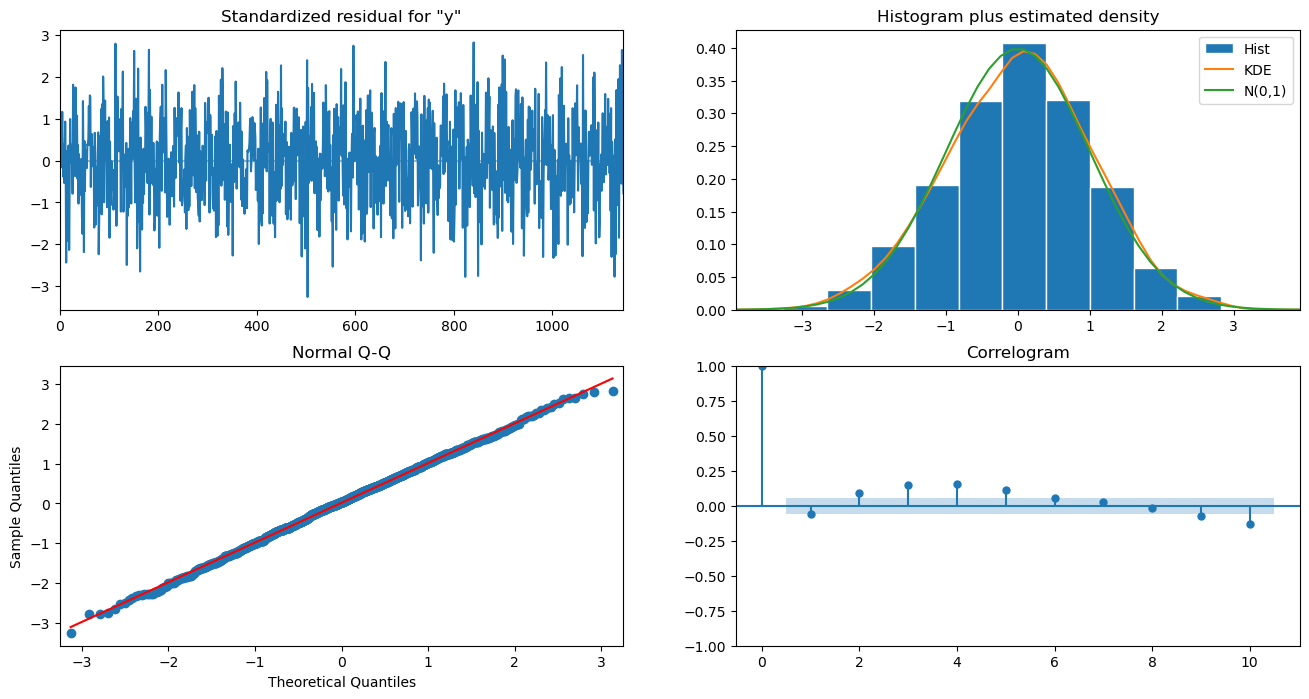

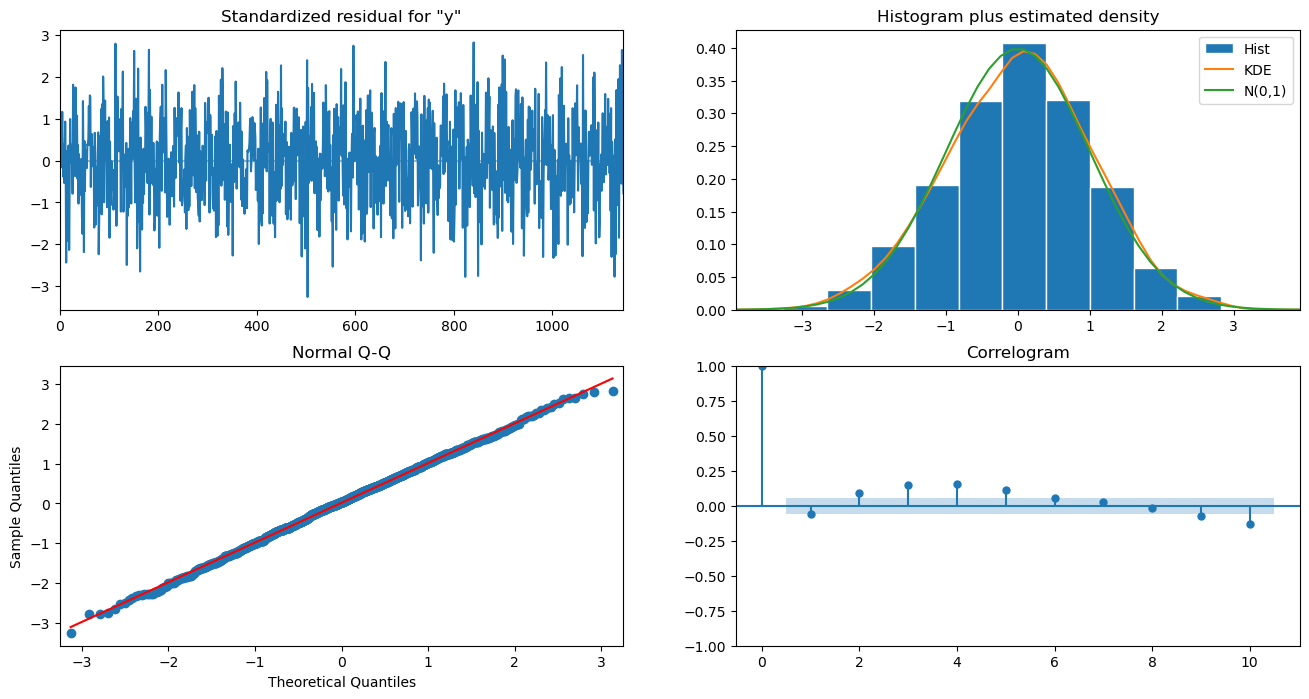

In [84]:
# давайте отпринтуем результаты проверки остатков модели
# print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci.results.results.resid)[1])
# print("p-value тест Стьюдента = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value тест Стьюдента = %f" % ttest_1samp(ci.results.results.resid, 0)[1])
# print("p-value тест Льюнга-Бокса = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
print("p-value тест Льюнга-Бокса = %f" % ci.results.results.test_serial_correlation('ljungbox')[0, :, 0][1])
# ci.trained_model.plot_diagnostics(figsize = (16, 8))
ci.results.results.plot_diagnostics(figsize = (16, 8))

По стат. критерию Дики-Фуллера а так же по графику стандартизированного распределения остатков, можно увидеть что остатки стационарны.

По графику гистограммы распределения остатков, можем наблюдать что остатки несмещены и ср. значение находится близко к нулю. t-test не позволят отвергнуть гипотезу о несмещенности.

По стат. критерию Q-критерия Льюнга-Бокса, гипотеза H0 об отсутствии автокрреляции отвергается. Но по графику коррелограммы, видно что остатки мало автокррелирваонны.